# Convolutional LSTM for coordinate prediction

In [1]:
'''
Imports external and own libraries
'''

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from tqdm.auto import tqdm

# own
import common.action as action
import common.world as world
import common.plot as plot
import common.preprocess as preprocess
import common.nets as nets
import common.train as train
import common.tools as tools

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


### Load datasets

In [2]:
with open('datasets/oracle_data.pickle', 'rb') as handle:
    oracle_data = pickle.load(handle)

with open('datasets/oracle_reversed_data.pickle', 'rb') as handle:
    oracle_reversed_data = pickle.load(handle)

with open('datasets/oracle_random_data.pickle', 'rb') as handle:
    oracle_random_data = pickle.load(handle)

### Preprocess data

In [3]:
length_trajectory = 10
batch_size = 128

# split and shuffle data
train_data, test_data = preprocess.split_data_for_trajectories(oracle_reversed_data, 0.8, length_trajectory)
train_imgs, train_pos = preprocess.process_trajectory(train_data)
test_imgs, test_pos = preprocess.process_trajectory(test_data)

# stage data for the DataLoader
train_data = preprocess.ObtainDataset_notransform(train_imgs, train_pos)
test_data = preprocess.ObtainDataset_notransform(test_imgs, test_pos)

# preprocess trainingset 
dataset_loader_train_data = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataset_loader_test_data = DataLoader(test_data, batch_size=batch_size, shuffle=True)

### Initialize models

In [4]:
# initialize network
net_cnn = nets.CNN()
net_lstm = nets.LSTM(length_trajectory)

# check network
h0 = torch.randn(2, 10, 100)
c0 = torch.randn(2, 10, 100)

x = torch.rand((64, 10, 3, 32, 32))
features = net_cnn(x)
out0, out1, hidden, c = net_lstm(features, h0, c0)

# shape statistics
print('input cnn:', x.shape, '- Batch size, Channel out, Height out, Width out')
print('output cnn:', features.shape, " - Batch size, sequence length, input size")
print('input lstm:', features.shape, " - Batch size, sequence length, input size")
print('hidden lstm:', hidden[0].shape, '\n')
print('output lstm:', out0.shape)


# network summary

print('SUMMARY CNN \n', summary(net_cnn, (64, 10, 3, 32, 32)), '\n')
print('SUMMARY LSTM \n', summary(net_lstm, ((64, 10, 480), (2, 10, 100), (2, 10, 100))))

input cnn: torch.Size([64, 10, 3, 32, 32]) - Batch size, Channel out, Height out, Width out
output cnn: torch.Size([64, 10, 480])  - Batch size, sequence length, input size
input lstm: torch.Size([64, 10, 480])  - Batch size, sequence length, input size
hidden lstm: torch.Size([10, 100]) 

output lstm: torch.Size([64, 10])
SUMMARY CNN 
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10, 480]             --
├─Conv2d: 1-1                            [640, 10, 28, 28]         760
├─Conv2d: 1-2                            [640, 20, 24, 24]         5,020
├─MaxPool2d: 1-3                         [640, 20, 12, 12]         --
├─Conv2d: 1-4                            [640, 30, 8, 8]           15,030
├─MaxPool2d: 1-5                         [640, 30, 4, 4]           --
Total params: 20,810
Trainable params: 20,810
Non-trainable params: 0
Total mult-adds (G): 2.85
Input size (MB): 7.86
Forward/backward pass size (MB): 108.95
P

### Train the model

In [5]:
criterion = nn.MSELoss()
params = list(net_cnn.parameters()) + list(net_lstm.parameters())
optimizer = optim.Adam(params, lr=0.01)
episodes = 10

train_loss, test_loss, train_dis, test_dis, train_dis_item, test_dis_item  = train.train_ConvLSTM(dataset_loader_train_data, dataset_loader_test_data,
                                                                                   net_cnn, net_lstm, criterion, optimizer, episodes, length_trajectory)

Progress:   0%|          | 0/10 [00:00<?, ? Episode/s]

Epoch: 1, Train Loss: 455.1, Train distance: 19.83, , Test distance: 16.22
Finished Training


In [12]:
# needs to be adopted to take into account that 64*10*1 values! (wrong dimensions?)
from statistics import mean

train_dis_notensor  = []
for i in train_dis:
    i = i.detach().numpy()
    i = i.item()
    train_dis_notensor.append(i)
    
test_dis_notensor  = []
for i in test_dis:
    test_dis_notensor.append(float(i))
    
train_dis_item_notensor  = []
for i in train_dis_item:
    i = i.detach().numpy()
    train_dis_item_notensor.extend(i)

test_dis_item_notensor  = []
for i in test_dis_item:
    i = i.detach().numpy()
    test_dis_item_notensor.extend(i)
    
values = []
for packs in test_dis_item_notensor:
    values.append(mean(packs))

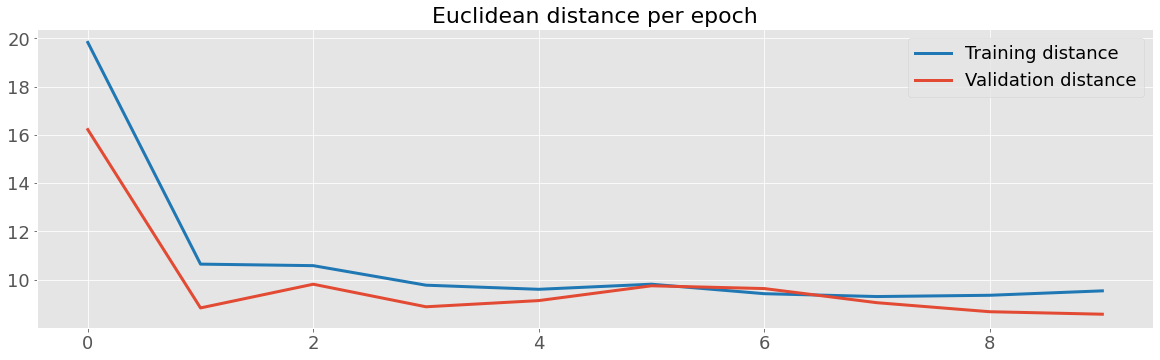

In [13]:
import torch

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 20, 5.5
    
with plt.style.context('ggplot'):
    plt.plot(train_dis_notensor[:], label = "Training distance", linewidth=3, color='tab:blue')
    plt.plot(test_dis_notensor[:], label = "Validation distance", linewidth=3)
    plt.title('Euclidean distance per epoch', fontsize=22)
    plt.legend(fontsize=18)
    plt.show()

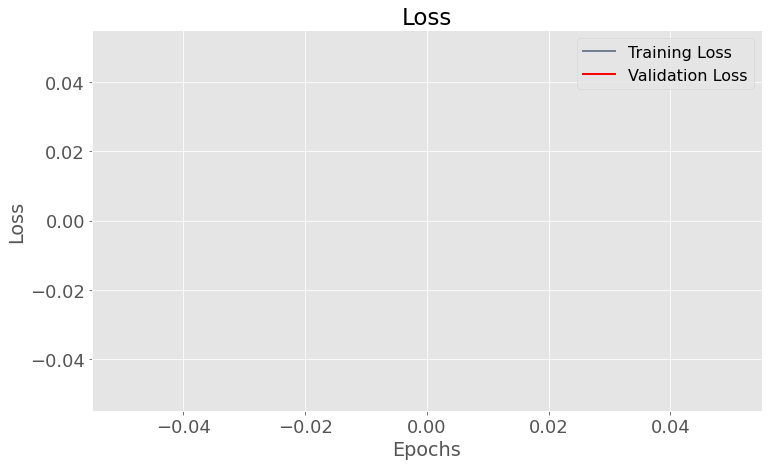

In [14]:
plot.plot_losses(train_loss[10:], test_loss[10:])

ValueError: The 'color' keyword argument must have one color per dataset, but 1270 datasets and 1 colors were provided

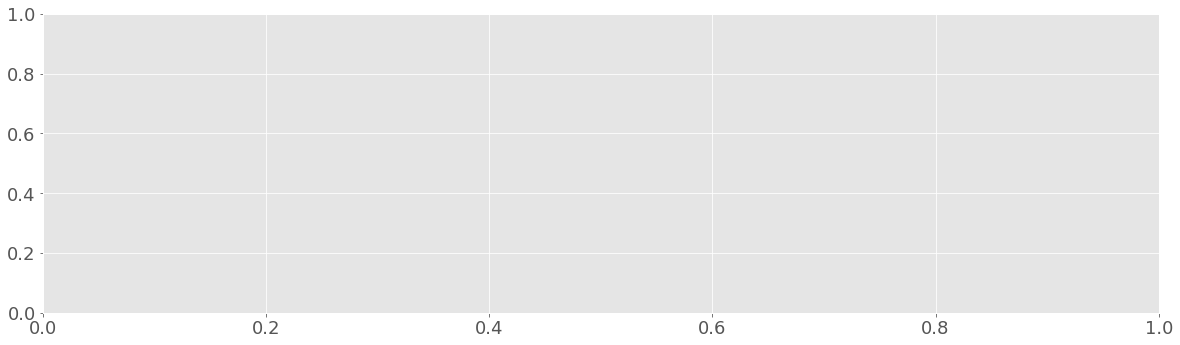

In [15]:
import statistics

plt.rcParams['figure.figsize'] = 20, 5.5
plt.rcParams.update({'font.size': 25})
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)

with plt.style.context('ggplot'):
    max_lim = 17
    plt.hist(train_dis_item_notensor[10:], bins=50, rwidth=0.9, color='#607c8e', range=(0, max_lim), alpha=0.9)
    plt.xlabel('Distance', fontsize=20)
    plt.ylabel('Amount', fontsize=20)
    plt.title('Training set - Distances (50 bins)', fontsize=22)
    mean_val = statistics.mean(train_dis_item_notensor[10:])
    plt.text(mean_val*1.1, max_lim*0.9, 'Mean: {:.2f}'.format(mean_val), fontsize=22)
    plt.axvline(mean_val, color='k', linestyle='dashed', linewidth=2)
    plt.show()

with plt.style.context('ggplot'):
    plt.hist(test_dis_item_notensor[10:], bins=50, rwidth=0.9, color='indianred', range=(0, 17), alpha=0.9)
    plt.xlabel('Distance', fontsize=20)
    plt.ylabel('Amount', fontsize=20)
    plt.title('Validation set - Distances (50 bins)', fontsize=22)
    mean_val = statistics.mean(test_dis_item_notensor[10:])
    plt.text(mean_val*1.1, max_lim*0.9, 'Mean: {:.2f}'.format(mean_val), fontsize=22)
    plt.axvline(mean_val, color='k', linestyle='dashed', linewidth=2)
    plt.show()